# 캐글 신용카드 사기 검출
---

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import *

# 오차행렬, 정확도, 정밀도, 재현율을 한번에 출력하기 위한 함수 정의 

def get_clf_eval(y_test, pred=None, pred_proba=None): 
    confusion = confusion_matrix(y_test, pred) 
    accuracy = accuracy_score(y_test, pred) 
    precision = precision_score(y_test, pred) 
    recall = recall_score(y_test, pred) 
    f1 = f1_score(y_test, pred) 
    # ROC AUC 
    roc_auc = roc_auc_score(y_test, pred_proba) 
    print('Confusion Matrix') 
    print(confusion) 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, roc_auc: {4:.4f}'.format( accuracy, precision, recall, f1, roc_auc))

In [2]:
df = pd.read_csv('../data/creditcard_frauddetection/creditcard.csv')
df['Class'].value_counts()/len(df)

0    0.998273
1    0.001727
Name: Class, dtype: float64

신용카드 사기, 암 확진 등의 데이터셋은 데이터의 특성 상 극도의 레이블 분균형한 분포를 가지기 쉽습니다. 따라서 언더 샘플링과 오버 샘플링에 대한 이해가 필요합니다.

# 언더 샘플링과 오버 샘플링의 이해
---

이처럼 레이블의 불균형이 심한 경우 ML 모델이 다양한 학습 유형을 학습하지 못하며 일방적으로 정상 레이블에 치우쳐진 상태로 학습되어 이상치 검출이 어려워질 수 있습니다.

따라서 이러한 문제를 해결하기 위한 방법으로 `언더 샘플링(Undersampling)`과 `오버 샘플링(Oversampling)`이 사용되는데 `일반적으로 오버 샘플링 방식이 ML 성능상 더 유리한 경우가 많습니다.`

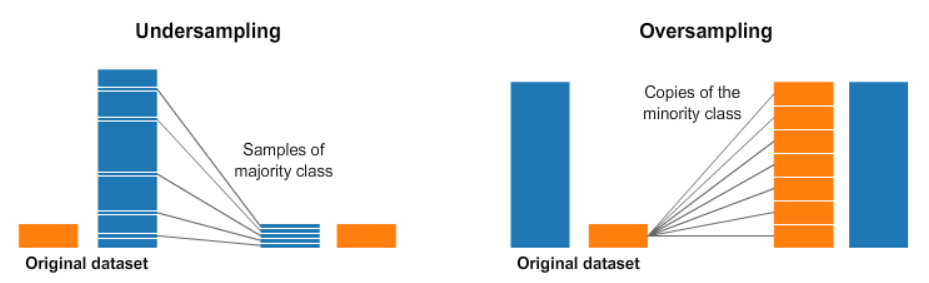

- **언더 샘플링**은 원본 데이터에서 많은 분포를 차지하는 정상 데이터를 이상치 데이터의 수로 줄여버리는 방식이며 정상 데이터를 과도하게 줄여버리는 방식이기 때문에 오히려 정상적인 학습이 어렵다는 단점이 존재합니다.


- **오버 샘플링**은 이상치 데이터를 증식시켜 정상치 데이터 만큼 학습을 위한 데이터를 확보하는 방식이며 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식합니다. 이를 위해 SMOTE(Synthetic Minority Over-sampling Technique) 방법을 이용합니다.

# SMOTE(Synthetic Minority Over-sampling Technique)란?
---

SMOTE란 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Neares Neighbor)을 찾아 신규 증식 대상을 설정하고 기존 데이터와 약간의 차이를 가진 새로운 데이터를 생성하는 방식입니다.

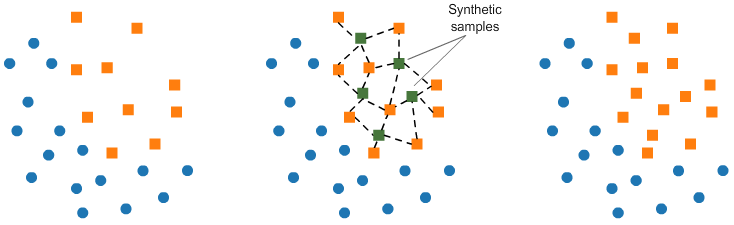

# 데이터 1차 가공 및 모델 학습/예측/평가
---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
# 결측치 없음

df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
df.shape

(284807, 31)

In [6]:
#  클래스를 제외한 모든 피쳐가 float 데이터 타입

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

아래의 함수를 통해 Time 피처를 제거한 DF를 Stratify(계층적 샘플링) 기반 분할 방식을 이용해 동일한 레이블 분포를 가진 train, test set을 생성합니다.

In [7]:
from sklearn.model_selection import train_test_split

# 인자로 입력된 df를 copy한 후 Time 피처를 제거한 복사본 df 를 반환
def get_processed_df(df=None):
    df_copy = df.copy()
    df_copy.drop("Time", axis=1, inplace=True)
    return df_copy

# 사전 데이터 가공 후 학습, 테스트 데이터 세트를 반환
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DF 반환
    df_copy = get_processed_df(df)
    
    # DF의 맨 마지막 컬럼에 레이블, 나머지는 피처
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    # train_test_split()으로 train, test데이터 분리, stratify=y_target으로 지정해 Stratified(계층적 샘플링) 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, stratify=y_target)
    
    print("----------------------------X_train, X_test SHAPE----------------------------")
    print(X_train.shape, X_test.shape)
    print("----------------------------y_train, y_test DISTRIBUTION----------------------------")
    print(y_train.value_counts()/len(y_train)*100)
    print(y_test.value_counts()/len(y_test)*100)
    
    # train, tests 데이터셋 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

----------------------------X_train, X_test SHAPE----------------------------
(199364, 29) (85443, 29)
----------------------------y_train, y_test DISTRIBUTION----------------------------
0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64


train, test데이터의 레이블 분포가 동일하게 분리되었지만 원본 데이터 자체의 레이블 불균형이 매우 심한 상태입니다.

이 상태 그대로 분류 모델에 학습시키는 경우 어떠한 문제가 발생하는지 알아보겠습니다.

# 로지스틱회귀 분류모델
---

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,-1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

Confusion Matrix
[[85285    10]
 [   45   103]]
accuracy: 0.9994, precision: 0.9115, recall: 0.6959, f1: 0.7893, roc_auc: 0.9626


# LightGBM

---

반복적으로 모델을 변경해 학습/예측/평가를 진행하는 함수를 계속 사용하기위해 아래의 코드를 작성합니다.


In [9]:
# 인자로 사이킷런 Estimator 객체와 train, test 데이터 셋을 입력받아 학습/예측/평가 수행

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [10]:
from lightgbm import LGBMClassifier

# 본 데이터 세트는 불균형 레이블을 가져 boost_from_average를 False로 지정합니다.
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

Confusion Matrix
[[85290     5]
 [   21   127]]
accuracy: 0.9997, precision: 0.9621, recall: 0.8581, f1: 0.9071, roc_auc: 0.9857


회귀모델의 경우 ROC_AUC 값이 0.9652였는데 LGBM 모델의 ROC_AUC는 0.9797로 성능이 개선되었습니다.


# 데이터 분포도 변환 후 모델 학습/예측/평가
----


로지스틱 회귀 모델은 선형 모델로 중요 피처의 값이 정규분포 형태를 유지하는 것이 중요하며
신용카드 사용 금액은 이상치 검출에 매우 중요한 피처일 가능성이 높습니다. 따라서 신용카드 사용량 데이터의 분포를 확인합니다.

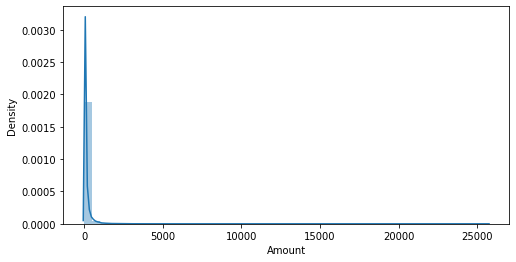

In [11]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.distplot(df['Amount'])
plt.show()

신용카드 사용량이 1000 달러 이하인 데이터가 무려 약 99퍼센트에 이릅니다. 그럼에도 불구하고 위 히스토그램에서도 알 수 있듯이 25000불 까지의 사용량이 낮게 분포된 것을 확인할 수 있습니다.

In [12]:
len(df[df['Amount']<=1000])/len(df)

0.9896772200121485

이렇게 분포가 불균형한 데이터를 회귀 기반 모델의 성능을 높이기 위해 정규 분포 형태로 변환하는 작업을 진행합니다.


# 분균형 피처 정규분포 형태 변환
---

회귀 기반 모델의 성능을 높이기 위한 방법으로 StandardScaler 객체를 통해 Amount 피처를 정규 분포 형태로 변환합니다. 

In [13]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_tarnsform(df_copy["Amount"].values.reshape(-1,1))
    
    # 변환된 Amount를 Amount_sclaed로 피처명 변경
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [14]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀, LGBM모델 학습/예측/평가

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('------------------------------------로지스틱 회귀 모델 예측 성능------------------------------------')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('------------------------------------LGBM 모델 예측 성능------------------------------------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

----------------------------X_train, X_test SHAPE----------------------------
(199364, 29) (85443, 29)
----------------------------y_train, y_test DISTRIBUTION----------------------------
0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64
------------------------------------로지스틱 회귀 모델 예측 성능------------------------------------
Confusion Matrix
[[85274    21]
 [   59    89]]
accuracy: 0.9991, precision: 0.8091, recall: 0.6014, f1: 0.6899, roc_auc: 0.9414
------------------------------------LGBM 모델 예측 성능------------------------------------
Confusion Matrix
[[85290     5]
 [   32   116]]
accuracy: 0.9996, precision: 0.9587, recall: 0.7838, f1: 0.8625, roc_auc: 0.9719


Standard Scaler를 이용해 Amount 피처를 표준 정규분포 형태로 변환했지만 눈에띄는 성능 개선은 보이지 않습니다.

이러서 Standard Scaler 대신 로그 변환을 진행합니다.

로그 변환 기법은 데이터 분포가 심하게 왜곡된 경우에 적용하는 방법으로 원래 값에 로그를 취해 상대적으로 작은 값으로 변환해 데이터 분포의 왜곡을 상당 수준 개선합니다.

In [15]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()

    # 넘파이의 log1p() 이용, Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    
    # 변환된 Amount를 Amount_sclaed로 피처명 변경
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [16]:
# Amount를 로그 변환 후 로지스틱 회귀, LGBM모델 학습/예측/평가

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('------------------------------------로지스틱 회귀 모델 예측 성능------------------------------------')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('------------------------------------LGBM 모델 예측 성능------------------------------------')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

----------------------------X_train, X_test SHAPE----------------------------
(199364, 29) (85443, 29)
----------------------------y_train, y_test DISTRIBUTION----------------------------
0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64
------------------------------------로지스틱 회귀 모델 예측 성능------------------------------------
Confusion Matrix
[[85275    20]
 [   52    96]]
accuracy: 0.9992, precision: 0.8276, recall: 0.6486, f1: 0.7273, roc_auc: 0.9562
------------------------------------LGBM 모델 예측 성능------------------------------------
Confusion Matrix
[[85289     6]
 [   34   114]]
accuracy: 0.9995, precision: 0.9500, recall: 0.7703, f1: 0.8507, roc_auc: 0.9731


Amount 피처를 로그로 변환한 결과 두 모델 모두 약간의 성능 개선이 이루어졌습니다.

# 이상치 데이터 제거 후 모델 학습/평가/예측
---

이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터를 의미합니다.

이러한 Outlier를 찾아내는 방법으로는 **IQR(Inter Quantile Range)** 방식을 이용할 수 있으며 이는 사분위(Quantile) 값의 편차를 이용하는 기법이기 때문에 Boxplot으로 시각화가 가능합니다.

**(IQR = Q1 ~ Q3 구간)**

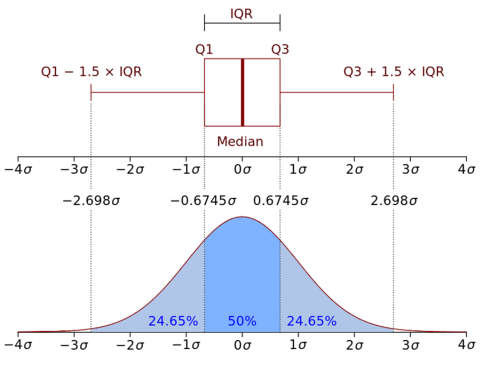

위 Boxplot에서도 알 수 있듯이 IQR에 1.5를 곱해 이보다 크거나 작은 값은 이상치로 간주하는 것입니다. 

IQR 방식을 이용해 이상치 데이터를 식별하고 제거하는 작업을 진행해보겠습니다.

IQR 방식을 이용한 이상치 데이터 식별을 위해선 먼저 피처의 선택이 선행되어야 하는데 선택 기준은 레이블과의 상관관계입니다.

<AxesSubplot:>

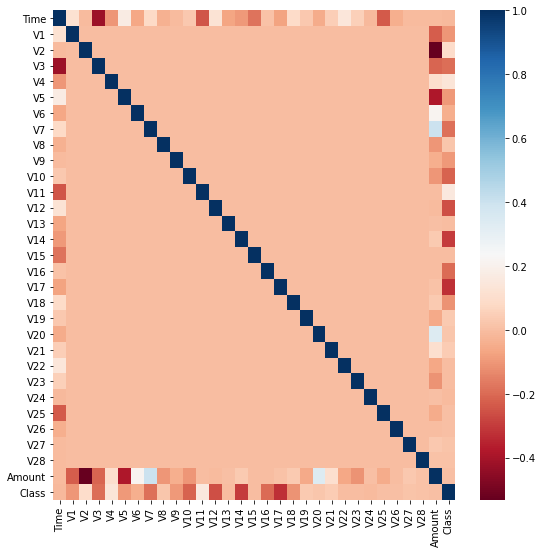

In [17]:
import seaborn as sns

plt.figure(figsize=(9, 9))
sns.heatmap(df.corr(), cmap='RdBu')

위 상관관계 히트맵을 이용해 양의 상관관계가 높다면 푸른색으로 표시되고 음의 상관관계에 가까울수록 빨간색으로 표시됩니다

위 히트맵을 통해 알 수 있는 것은 Class와 음의 상관관계가 높은 피처는 V14와 V17입니다. 

In [18]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점 도출
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최댓값보다 크거나 작은 값을 이상치로 설정
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [19]:
outlier_index = get_outlier(df=df, column='V14', weight=1.5)
print('아웃라이어 인덱스 : ', outlier_index)

아웃라이어 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


먼저 V14 피처에 대한 아웃라이어 인덱스를 추출한 결과 위와 같은 아웃라이어를 찾아낼 수 있습니다.

In [20]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()

    # 넘파이의 log1p() 이용, Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    
    # 변환된 Amount를 Amount_sclaed로 피처명 변경
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    # 아웃라이어 제거
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

# 아웃라이어 제거 후 로지스틱 회귀, LGBM모델 학습/예측/평가

X_train, X_test, y_train, y_test = get_train_test_dataset(df)

print('------------------------------------로지스틱 회귀 모델 예측 성능------------------------------------')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('------------------------------------LGBM 모델 예측 성능------------------------------------')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

----------------------------X_train, X_test SHAPE----------------------------
(199364, 29) (85443, 29)
----------------------------y_train, y_test DISTRIBUTION----------------------------
0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64
------------------------------------로지스틱 회귀 모델 예측 성능------------------------------------
Confusion Matrix
[[85276    19]
 [   60    88]]
accuracy: 0.9991, precision: 0.8224, recall: 0.5946, f1: 0.6902, roc_auc: 0.9608
------------------------------------LGBM 모델 예측 성능------------------------------------
Confusion Matrix
[[85289     6]
 [   30   118]]
accuracy: 0.9996, precision: 0.9516, recall: 0.7973, f1: 0.8676, roc_auc: 0.9747


아웃라이어를 제거한 결과 두 모델 모두 예측 성능이 향상된것을 확인할 수 있습니다.

# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
---

이번에는 SMOTE 기법을 이용한 오버 샘플링을 적용해 두 모델에 대한 예측 성능을 평가해보겠습니다.

SMOTE을 적용할 때 주의할 점은 반드시 학습 데이터 세트만 오버 샘플링을 진행해야 한다는 점입니다.

**`검증 세트나 테스트 세트에 대해 오버 샘플링을 진행하게 되면 결국 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행해 올바른 검증/테스트가 될 수 없기 때문입니다.`**

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199364, 29) (199364,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


SMOTE를 적용한 데이터 세트의 크기는 약 두배에 가까운 398040 건으로 늘어난 것을 확인할 수 있습니다.

또한 레이블 값의 분포 역시 0과 1이 동일하게 오버 샘플링 된 것을 확인할 수 있습니다.

In [22]:
# 로지스틱 회귀 모델

lr_clf = LogisticRegression()

# ftr_train과 tgt_train 인자값으로 SMOTE 증식된 X_train_over, y_train_over로 변경
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train =y_train_over, tgt_test=y_test)

Confusion Matrix
[[83608  1687]
 [   14   134]]
accuracy: 0.9801, precision: 0.0736, recall: 0.9054, f1: 0.1361, roc_auc: 0.9796


로지스틱 회귀 모델의 경우 SMOTE 데이터로 학습을 진행한 결과 재현율은 높은 반면 정밀도가 매우 저조하게 나타납니다. 

이는 실제 원본 데이터 유형보다 사기 데이터를 너무 많이 학습하게 되어 테스트 데이터에 대해 사기로 예측을 수행한 결과 정밀도가 급격히 하락한 것입니다.

In [23]:
def precision_recall_curve_plot(y_test, pred_proba_c1): 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1) 
    
    plt.figure(figsize=(8, 6)) 
    threshold_boundary = thresholds.shape[0] 
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision') 
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall') 
    start, end = plt.xlim() 
    plt.xticks(np.round(np.arange(start, end, 0.1), 2)) 
    plt.xlabel('Threshold value') 
    plt.ylabel('Precision and Recall value')
    plt.legend() 
    plt.grid() 
    plt.show()

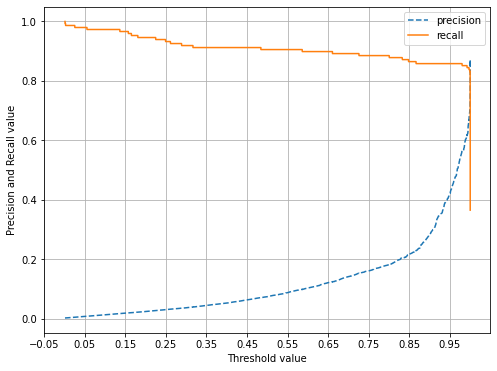

In [25]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,-1])

위 Precision Recall curve로 확인할 수 있는 것은 임계값이 0.99 이하일 때 Recall 값은 매우 높은 반면 Precision 값은 매우 낮은 상태임을 알 수 있고 임계값이 높아지면서 0.99를 넘어가는 순간 Recall 값이 급격하게 하락하고 Precision 값이 급격하게 상승합니다.

이렁 경우는 임계값을 조정하더라도 민감도가 너무 심해 올바른 성능의 모델을 구현하기 어렵습니다.

이번에는 LGBM을 이용해 SMOTE으로 오버 샘플링 된 데이터를 학습합니다.

In [26]:
# LGBM 모델 SMOTE 데이터 학습

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1, boost_from_eval=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train =y_train_over, tgt_test=y_test)

[LightGBM] [Warning] Unknown parameter: boost_from_eval
Confusion Matrix
[[85276    19]
 [   26   122]]
accuracy: 0.9995, precision: 0.8652, recall: 0.8243, f1: 0.8443, roc_auc: 0.9730


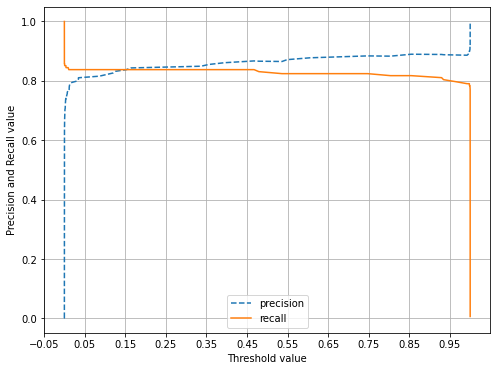

In [27]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:,-1])

LGBM 모델 역시 재현율은 높지만 정밀도는 이전보다 낮아졌습니다. 이처럼 SMOTE 패키지를 이용하면 재현율은 높아지지만 정밀도는 낮아지는 것이 일반적입니다.